# Libraries

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
import pydot
from IPython.display import Image
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import make_column_transformer

# Import data

In [3]:
og_df = pd.read_csv('habitaclia.csv')
og_df

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR
0,https://www.habitaclia.com/alquiler-piso-con_4...,Piso,Nicolas fuster,"Piso con 4 habitaciones con ascensor, parking,...",Pinto,San José-Buenos Aires,149,4,2,6.55,976,No,Sí
1,https://www.habitaclia.com/alquiler-piso-solvi...,Piso,C/ san antoni,Solvia inmobiliaria - piso parla,Parla,Reyes,62,3,1,12.74,790,No,-
2,https://www.habitaclia.com/alquiler-piso-con_3...,Piso,Pinto,Piso con 3 habitaciones con ascensor,Parla,Calle Pinto-San Roque,68,3,1,12.50,850,No,Sí
3,https://www.habitaclia.com/alquiler-piso-la_se...,Piso,La Serna,NaN,Fuenlabrada,La Serna,77,2,1,12.66,975,25,-
4,https://www.habitaclia.com/alquiler-piso-solvi...,Piso,Pz lugo,Solvia inmobiliaria - piso fuenlabrada,Fuenlabrada,El Naranjo,94,3,1,8.78,825,35,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,https://www.habitaclia.com/alquiler-piso-reyes...,Piso,"Calle alfonso xiii, 4",Reyes / calle alfonso xiii,Parla,Reyes,88,3,1,8.18,720,No,-
333,https://www.habitaclia.com/alquiler-apartament...,Apartamento,Calle alcalde ángel arroyo,Apartamento amueblado con ascensor y calefacción,Getafe,El Rosón-Kelvinator,65,1,1,15.23,990,No,Sí
334,https://www.habitaclia.com/alquiler-piso-capit...,Piso,Calle río jordán,¡capital home navalcarnero alquila fantástico ...,Parla,Parque Inlasa,81,2,1,10.19,825,No,-
335,https://www.habitaclia.com/alquiler-piso-parqu...,Piso,"Calle timanfaya, s/n",Parque lisboa - la paz / calle timanfaya,Alcorcón,Parque Lisboa-La Paz,70,2,1,15.71,1100,No,-


# ETL - Loading phase - Local RDDBB + SQL

In [41]:
def create_sqlite_database(filename):
    """ create a database connection to an SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(filename)
    except sqlite3.Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

In [ ]:
create_sqlite_database("my.db")

In [13]:
con = sqlite3.connect('my.db')

og_df.to_sql('Habitaclia', con, if_exists='replace', index=False, method='multi')

cursor = con.cursor()
query = 'SELECT * FROM Habitaclia'

mydb_df = pd.read_sql_query(query, con)
mydb_df

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR
0,https://www.habitaclia.com/alquiler-piso-con_4...,Piso,Nicolas fuster,"Piso con 4 habitaciones con ascensor, parking,...",Pinto,San José-Buenos Aires,149,4,2,6.55,976,No,Sí
1,https://www.habitaclia.com/alquiler-piso-solvi...,Piso,C/ san antoni,Solvia inmobiliaria - piso parla,Parla,Reyes,62,3,1,12.74,790,No,-
2,https://www.habitaclia.com/alquiler-piso-con_3...,Piso,Pinto,Piso con 3 habitaciones con ascensor,Parla,Calle Pinto-San Roque,68,3,1,12.50,850,No,Sí
3,https://www.habitaclia.com/alquiler-piso-la_se...,Piso,La Serna,None,Fuenlabrada,La Serna,77,2,1,12.66,975,25,-
4,https://www.habitaclia.com/alquiler-piso-solvi...,Piso,Pz lugo,Solvia inmobiliaria - piso fuenlabrada,Fuenlabrada,El Naranjo,94,3,1,8.78,825,35,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,https://www.habitaclia.com/alquiler-piso-reyes...,Piso,"Calle alfonso xiii, 4",Reyes / calle alfonso xiii,Parla,Reyes,88,3,1,8.18,720,No,-
333,https://www.habitaclia.com/alquiler-apartament...,Apartamento,Calle alcalde ángel arroyo,Apartamento amueblado con ascensor y calefacción,Getafe,El Rosón-Kelvinator,65,1,1,15.23,990,No,Sí
334,https://www.habitaclia.com/alquiler-piso-capit...,Piso,Calle río jordán,¡capital home navalcarnero alquila fantástico ...,Parla,Parque Inlasa,81,2,1,10.19,825,No,-
335,https://www.habitaclia.com/alquiler-piso-parqu...,Piso,"Calle timanfaya, s/n",Parque lisboa - la paz / calle timanfaya,Alcorcón,Parque Lisboa-La Paz,70,2,1,15.71,1100,No,-


# EDA - Exploratory Data Analysis

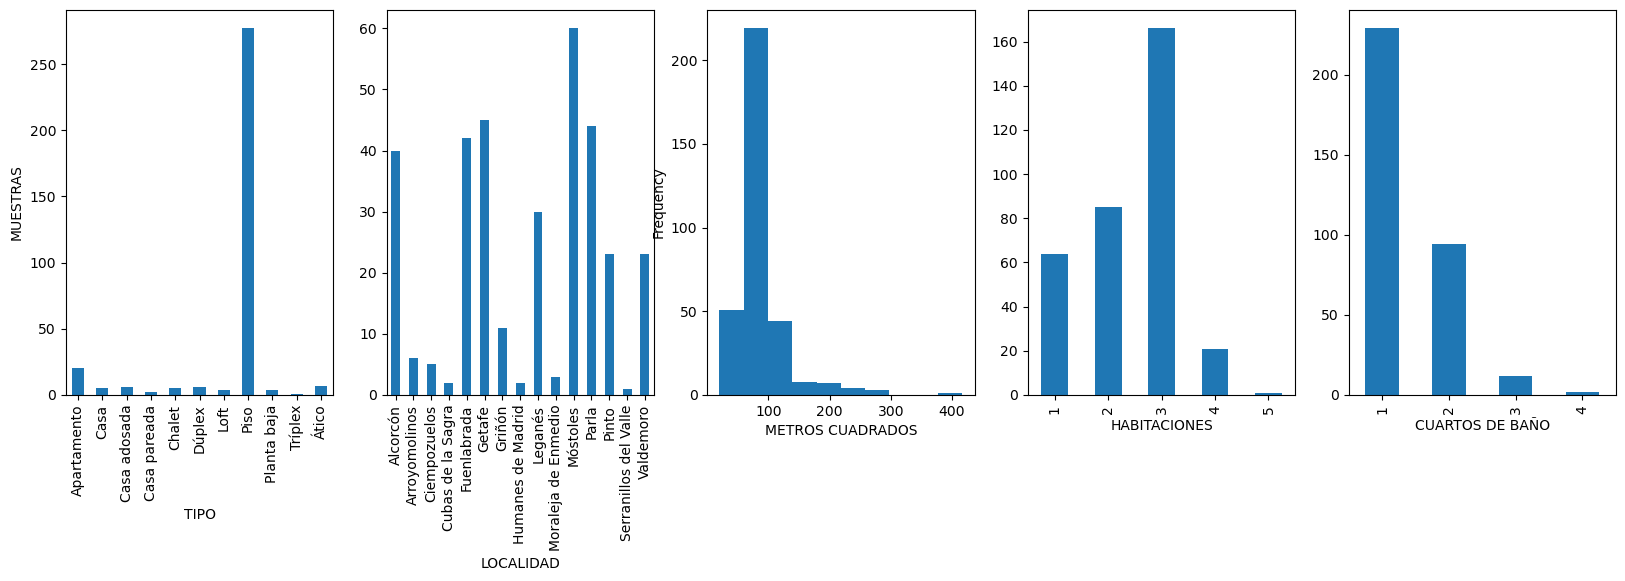

In [204]:
fig = plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
hab.groupby('TIPO').count()['LOCALIDAD'].plot(kind='bar')
plt.ylabel('MUESTRAS')
plt.subplot(1, 5, 2)
hab.groupby('LOCALIDAD').count()['TIPO'].plot(kind='bar')
plt.subplot(1, 5, 3)
hab['M*2'].plot(kind='hist')
plt.xlabel('METROS CUADRADOS')
plt.subplot(1, 5, 4)
hab.groupby('HAB').count()['LOCALIDAD'].plot(kind='bar')
plt.xlabel('HABITACIONES')
plt.subplot(1, 5, 5)
hab.groupby('BAÑOS').count()['LOCALIDAD'].plot(kind='bar')
plt.xlabel('CUARTOS DE BAÑO')


plt.show()

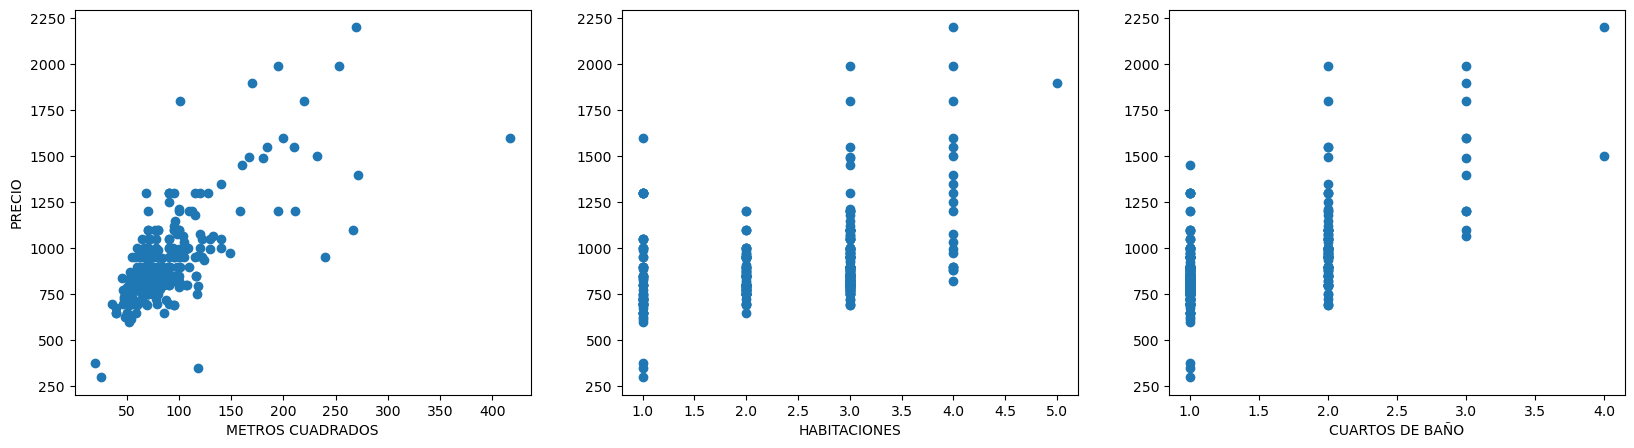

In [251]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.scatter(hab[['M*2']], hab[['PRECIO']])
plt.xlabel('METROS CUADRADOS')
plt.ylabel('PRECIO')
plt.subplot(1, 3, 2)
plt.scatter(hab[['HAB']], hab[['PRECIO']])
plt.xlabel('HABITACIONES')
plt.subplot(1, 3, 3)
plt.scatter(hab[['BAÑOS']], hab[['PRECIO']])
plt.xlabel('CUARTOS DE BAÑO')

plt.show()

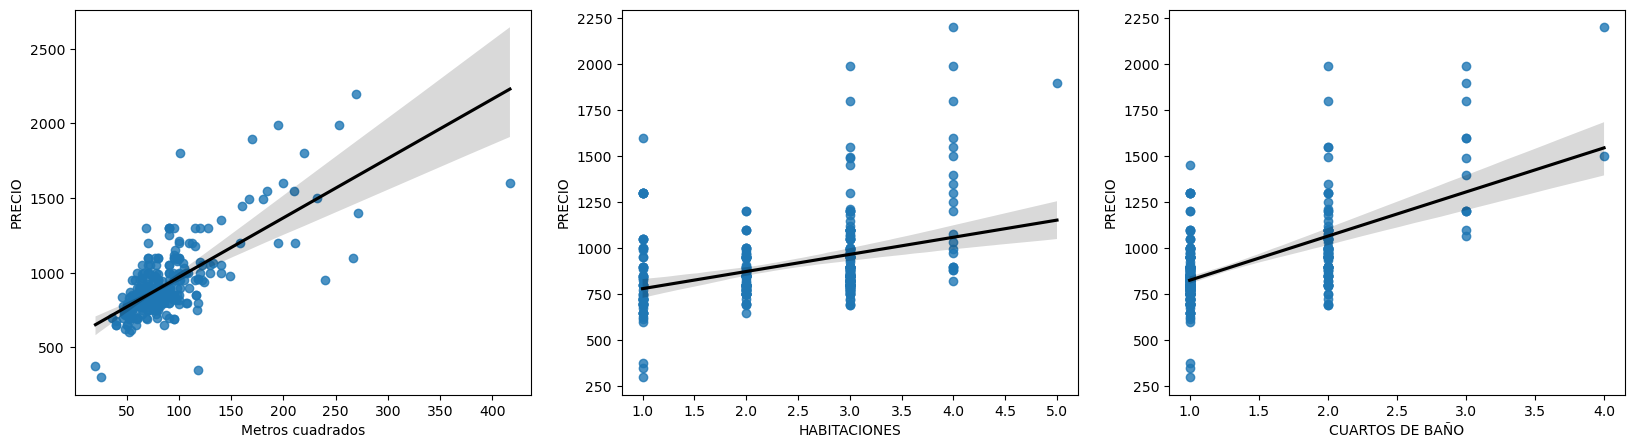

In [253]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.regplot(x='M*2', y='PRECIO', data=hab, line_kws={"color": "black"})
plt.xlabel('Metros cuadrados')
plt.ylabel('PRECIO')
plt.subplot(1, 3, 2)
sns.regplot(x='HAB', y='PRECIO', data=hab, line_kws={"color": "black"})
plt.xlabel('HABITACIONES')
plt.subplot(1, 3, 3)
sns.regplot(x='BAÑOS', y='PRECIO', data=hab, line_kws={"color": "black"})
plt.xlabel('CUARTOS DE BAÑO')

plt.show()

# Machine Learning - Predictive Modelling

## Multiple Linear Regression

In [409]:
hab = og_df[['TIPO', 'LOCALIDAD', 'ZONA', 'M*2', 'HAB', 'BAÑOS', 'ASCENSOR', 'PRECIO']]

### Data pre-processing

Categorical Encoding

- Variable/Column 'TIPO' by replacing using pandas 'replace' method
- Variable/Column 'LOCALIDAD' by One-Hot encoding using dummies

<Axes: xlabel='LOCALIDAD', ylabel='PRECIO'>

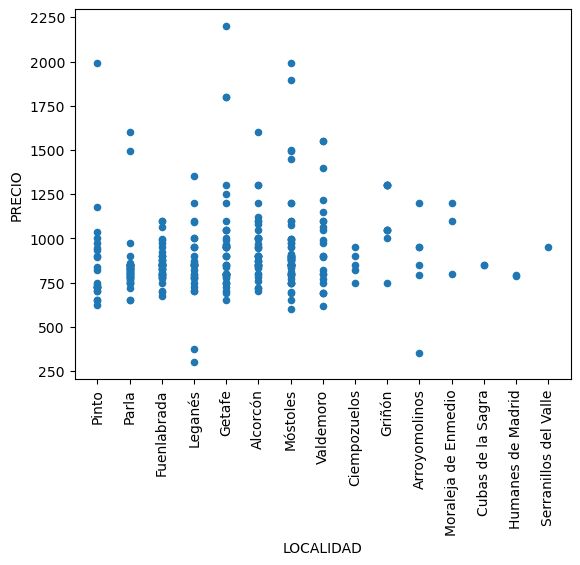

In [226]:
hab.plot(kind='scatter', x='LOCALIDAD', y='PRECIO', rot=90)

In [5]:
house_type = {'Estudio' : 1, 'Planta baja' : 2, 'Apartamento' : 3, 'Piso' : 4,
              'Loft' : 5, 'Ático': 6, 'Dúplex': 7, 'Tríplex': 8, 'Chalet': 9,
              'Casa adosada' : 10, 'Casa pareada' : 11, 'Casa' : 12}
hab['TIPO'] = hab['TIPO'].replace(house_type)

dummies_loc = pd.get_dummies(hab[['LOCALIDAD']])

hab = pd.concat([dummies_loc, hab[['TIPO', 'M*2', 'HAB', 'BAÑOS', 'PRECIO']]], axis=1)
hab

C:\Users\charl\AppData\Local\Temp\ipykernel_1880\1380097379.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hab['TIPO'] = hab['TIPO'].replace(house_type)


,LOCALIDAD_Alcorcón,LOCALIDAD_Arroyomolinos,LOCALIDAD_Ciempozuelos,LOCALIDAD_Cubas de la Sagra,LOCALIDAD_Fuenlabrada,LOCALIDAD_Getafe,LOCALIDAD_Griñón,LOCALIDAD_Humanes de Madrid,LOCALIDAD_Leganés,LOCALIDAD_Moraleja de Enmedio,LOCALIDAD_Móstoles,LOCALIDAD_Parla,LOCALIDAD_Pinto,LOCALIDAD_Serranillos del Valle,LOCALIDAD_Valdemoro,TIPO,M*2,HAB,BAÑOS,PRECIO
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,149,4,2,976
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,62,3,1,790
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,68,3,1,850
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,77,2,1,975
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,94,3,1,825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,88,3,1,720
333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,65,1,1,990
334,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,81,2,1,825
335,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,70,2,1,1100


In [275]:
pd.DataFrame({'Tipo':['Estudio', 'Planta baja', 'Apartamento', 'Piso', 'Loft', 'Ático', 'Dúplex', 'Tríplex', 'Chalet', 'Casa adosada', 'Casa pareada', 'Casa'],
              'Valor codificación': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})

,Tipo,Valor codificación
0,Estudio,1
1,Planta baja,2
2,Apartamento,3
3,Piso,4
4,Loft,5
5,Ático,6
6,Dúplex,7
7,Tríplex,8
8,Chalet,9
9,Casa adosada,10


Text(0, 0.5, 'PRECIO')

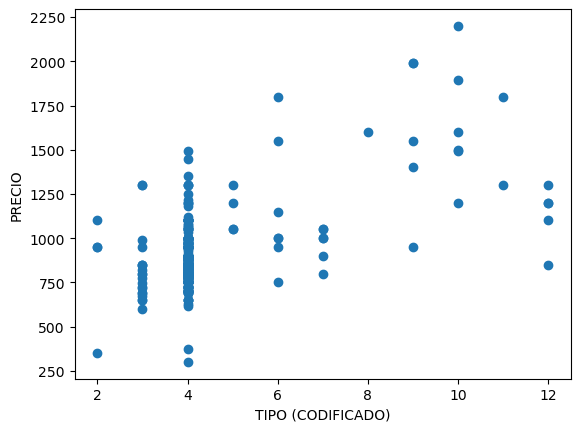

In [277]:
plt.scatter(hab[['TIPO']], hab[['PRECIO']])
plt.xlabel('TIPO (CODIFICADO)')
plt.ylabel('PRECIO')

In [319]:
dummies_loc

,LOCALIDAD_Alcorcón,LOCALIDAD_Arroyomolinos,LOCALIDAD_Ciempozuelos,LOCALIDAD_Cubas de la Sagra,LOCALIDAD_Fuenlabrada,LOCALIDAD_Getafe,LOCALIDAD_Griñón,LOCALIDAD_Humanes de Madrid,LOCALIDAD_Leganés,LOCALIDAD_Moraleja de Enmedio,LOCALIDAD_Móstoles,LOCALIDAD_Parla,LOCALIDAD_Pinto,LOCALIDAD_Serranillos del Valle,LOCALIDAD_Valdemoro
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
333,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
334,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
335,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
hab.to_csv('df_to_model.csv')

### Train-test split

In [7]:
x_var_names = list(hab)[:-1]
y_var_names = list(hab)[-1]
X = hab[x_var_names]
y = hab[y_var_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=0) #test_size=0.3, random_state=42)
print('Longitud datos:', len(y))
print("Dimensiones training:", X_train.shape[0])
print("Dimensiones test:", X_test.shape[0])

Longitud datos: 337
Dimensiones training: 269
Dimensiones test: 68


### Modelling

In [19]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2_LR = r2_score(y_test, y_pred)
mse_LR = mean_squared_error(y_test, y_pred)
print('r2 LR: ', r2_LR)
print('mse LR: ', mse_LR)

r2 LR:  0.7297047749508137
mse LR:  14240.78194298159


In [21]:
pd.DataFrame({'Coeficiente de determinación R2':[round(r2_LR, 2)],
              'Error cuadrático medio MSE':[round(mse_LR, 2)]})

,Coeficiente de determinación R2,Error cuadrático medio MSE
0,0.73,14240.78


In [606]:
coefs = [lr.intercept_]
coefs.extend(list(lr.coef_))
labels = ['bias']
labels.extend(x_var_names)

dict_coefs = {}
print("----")
for n,c in zip(labels,coefs):
    print
    print(n,str(round(c,4)))
    dict_coefs[n] = [round(c,4)]
    print("---------------")

print(dict_coefs)
pd.DataFrame(dict_coefs).T

----
bias 301.9197
---------------
LOCALIDAD_Alcorcón 121.7821
---------------
LOCALIDAD_Arroyomolinos -261.8732
---------------
LOCALIDAD_Ciempozuelos -81.2874
---------------
LOCALIDAD_Cubas de la Sagra 20.5978
---------------
LOCALIDAD_Fuenlabrada 20.7409
---------------
LOCALIDAD_Getafe 115.0063
---------------
LOCALIDAD_Griñón 226.0867
---------------
LOCALIDAD_Humanes de Madrid -70.3171
---------------
LOCALIDAD_Leganés 82.9823
---------------
LOCALIDAD_Moraleja de Enmedio -429.7403
---------------
LOCALIDAD_Móstoles 68.8758
---------------
LOCALIDAD_Parla -23.1099
---------------
LOCALIDAD_Pinto 24.2079
---------------
LOCALIDAD_Serranillos del Valle 151.7101
---------------
LOCALIDAD_Valdemoro 34.338
---------------
TIPO 37.3994
---------------
M*2 2.489
---------------
HAB 45.9787
---------------
BAÑOS 55.697
---------------
{'bias': [301.9197], 'LOCALIDAD_Alcorcón': [121.7821], 'LOCALIDAD_Arroyomolinos': [-261.8732], 'LOCALIDAD_Ciempozuelos': [-81.2874], 'LOCALIDAD_Cubas de l

,0
bias,301.9197
LOCALIDAD_Alcorcón,121.7821
LOCALIDAD_Arroyomolinos,-261.8732
LOCALIDAD_Ciempozuelos,-81.2874
LOCALIDAD_Cubas de la Sagra,20.5978
LOCALIDAD_Fuenlabrada,20.7409
LOCALIDAD_Getafe,115.0063
LOCALIDAD_Griñón,226.0867
LOCALIDAD_Humanes de Madrid,-70.3171
LOCALIDAD_Leganés,82.9823


## Regression Tree - Decission Tree for Regression

### Data pre-processing

Categorical Encoding

- Both variables 'TIPO' and 'LOCALIDAD' with label encoding

In [287]:
hab = og_df[['TIPO', 'LOCALIDAD', 'M*2', 'HAB', 'BAÑOS', 'PRECIO']]

enc = LabelEncoder()
hab['LOCALIDAD'] = enc.fit_transform(hab['LOCALIDAD'])
hab['TIPO'] = enc.fit_transform(hab['TIPO'])
# hab = hab.astype('float64')
hab.describe()

C:\Users\charl\AppData\Local\Temp\ipykernel_4360\3649394244.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hab['LOCALIDAD'] = enc.fit_transform(hab['LOCALIDAD'])
C:\Users\charl\AppData\Local\Temp\ipykernel_4360\3649394244.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hab['TIPO'] = enc.fit_transform(hab['TIPO'])


,TIPO,LOCALIDAD,M*2,HAB,BAÑOS,PRECIO
count,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000
mean,6.370920,7.290801,85.952522,2.436202,1.367953,914.382789
std,2.006415,4.189521,41.282319,0.877765,0.583437,228.201924
min,0.000000,0.000000,20.000000,1.000000,1.000000,300.000000
25%,7.000000,4.000000,65.000000,2.000000,1.000000,800.000000
50%,7.000000,8.000000,77.000000,3.000000,1.000000,850.000000
75%,7.000000,11.000000,95.000000,3.000000,2.000000,975.000000
max,10.000000,14.000000,417.000000,5.000000,4.000000,2200.000000


### Train-test split

In [321]:
x_var_names = list(hab)[:-1]
y_var_names = list(hab)[-1]
X = hab[x_var_names]
y = hab[y_var_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pd.DataFrame({'Muestras':[X_train.shape[0], y_train.shape[0], X_test.shape[0], y_test.shape[0]],
              'Atributos':[X_train.shape[1], 1, X_test.shape[1], 1]}, 
             index=['X_train', 'y_train', 'X_test', 'y_test'])

,Muestras,Atributos
X_train,269,5
y_train,269,1
X_test,68,5
y_test,68,1


### Modelling

In [363]:
#Regression Tree (No norm obv)

r2_regTree = 0.0
count = 0
d = {}
for depth in range(2, 11):
    l = []
    for nodes in range(5, 16):
        regTree = DecisionTreeRegressor(criterion='squared_error', max_depth=depth, max_leaf_nodes=nodes)
        regTree.fit(X_train, y_train)
        y_pred_regTree = regTree.predict(X_test)
        print('depth:', depth, 'nodes:', nodes, 'R2:', round(r2_score(y_test, y_pred_regTree), 3))
        if r2_score(y_test, y_pred_regTree) > r2_regTree:
            r2_regTree = r2_score(y_test, y_pred_regTree)
            
            params = [depth, nodes]
        l.append(round(r2_score(y_test, y_pred_regTree), 3))
    d[depth]=l
        

print(pd.DataFrame(d, index=list(range(5, 16))))        
print(params)        

depth: 2 nodes: 5 R2: 0.634
depth: 2 nodes: 6 R2: 0.634
depth: 2 nodes: 7 R2: 0.634
depth: 2 nodes: 8 R2: 0.634
depth: 2 nodes: 9 R2: 0.634
depth: 2 nodes: 10 R2: 0.634
depth: 2 nodes: 11 R2: 0.634
depth: 2 nodes: 12 R2: 0.634
depth: 2 nodes: 13 R2: 0.634
depth: 2 nodes: 14 R2: 0.634
depth: 2 nodes: 15 R2: 0.634
depth: 3 nodes: 5 R2: 0.673
depth: 3 nodes: 6 R2: 0.672
depth: 3 nodes: 7 R2: 0.677
depth: 3 nodes: 8 R2: 0.677
depth: 3 nodes: 9 R2: 0.677
depth: 3 nodes: 10 R2: 0.677
depth: 3 nodes: 11 R2: 0.677
depth: 3 nodes: 12 R2: 0.677
depth: 3 nodes: 13 R2: 0.677
depth: 3 nodes: 14 R2: 0.677
depth: 3 nodes: 15 R2: 0.677
depth: 4 nodes: 5 R2: 0.673
depth: 4 nodes: 6 R2: 0.672
depth: 4 nodes: 7 R2: 0.671
depth: 4 nodes: 8 R2: 0.675
depth: 4 nodes: 9 R2: 0.688
depth: 4 nodes: 10 R2: 0.689
depth: 4 nodes: 11 R2: 0.695
depth: 4 nodes: 12 R2: 0.695
depth: 4 nodes: 13 R2: 0.682
depth: 4 nodes: 14 R2: 0.682
depth: 4 nodes: 15 R2: 0.682
depth: 5 nodes: 5 R2: 0.673
depth: 5 nodes: 6 R2: 0.672
de

In [365]:
regTree = DecisionTreeRegressor(criterion='squared_error', max_depth=5, max_leaf_nodes=13) #max_depth=params[0]
regTree.fit(X_train, y_train)
y_pred_regTree = regTree.predict(X_test)

r2_regTree = r2_score(y_test, y_pred_regTree)
mse_regTree = mean_squared_error(y_test, y_pred_regTree)
print("R2 RegTree Model: %.3f" % r2_regTree)
print("RMSE RegTree Model: %.3f" % mse_regTree)

R2 RegTree Model: 0.717
RMSE RegTree Model: 15658.613


In [373]:
pd.DataFrame({'Coeficiente de determinación R2':[round(r2_regTree, 3)],
              'Error cuadrático medio MSE':[round(mse_regTree, 2)]})

,Coeficiente de determinación R2,Error cuadrático medio MSE
0,0.717,15658.61


In [766]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

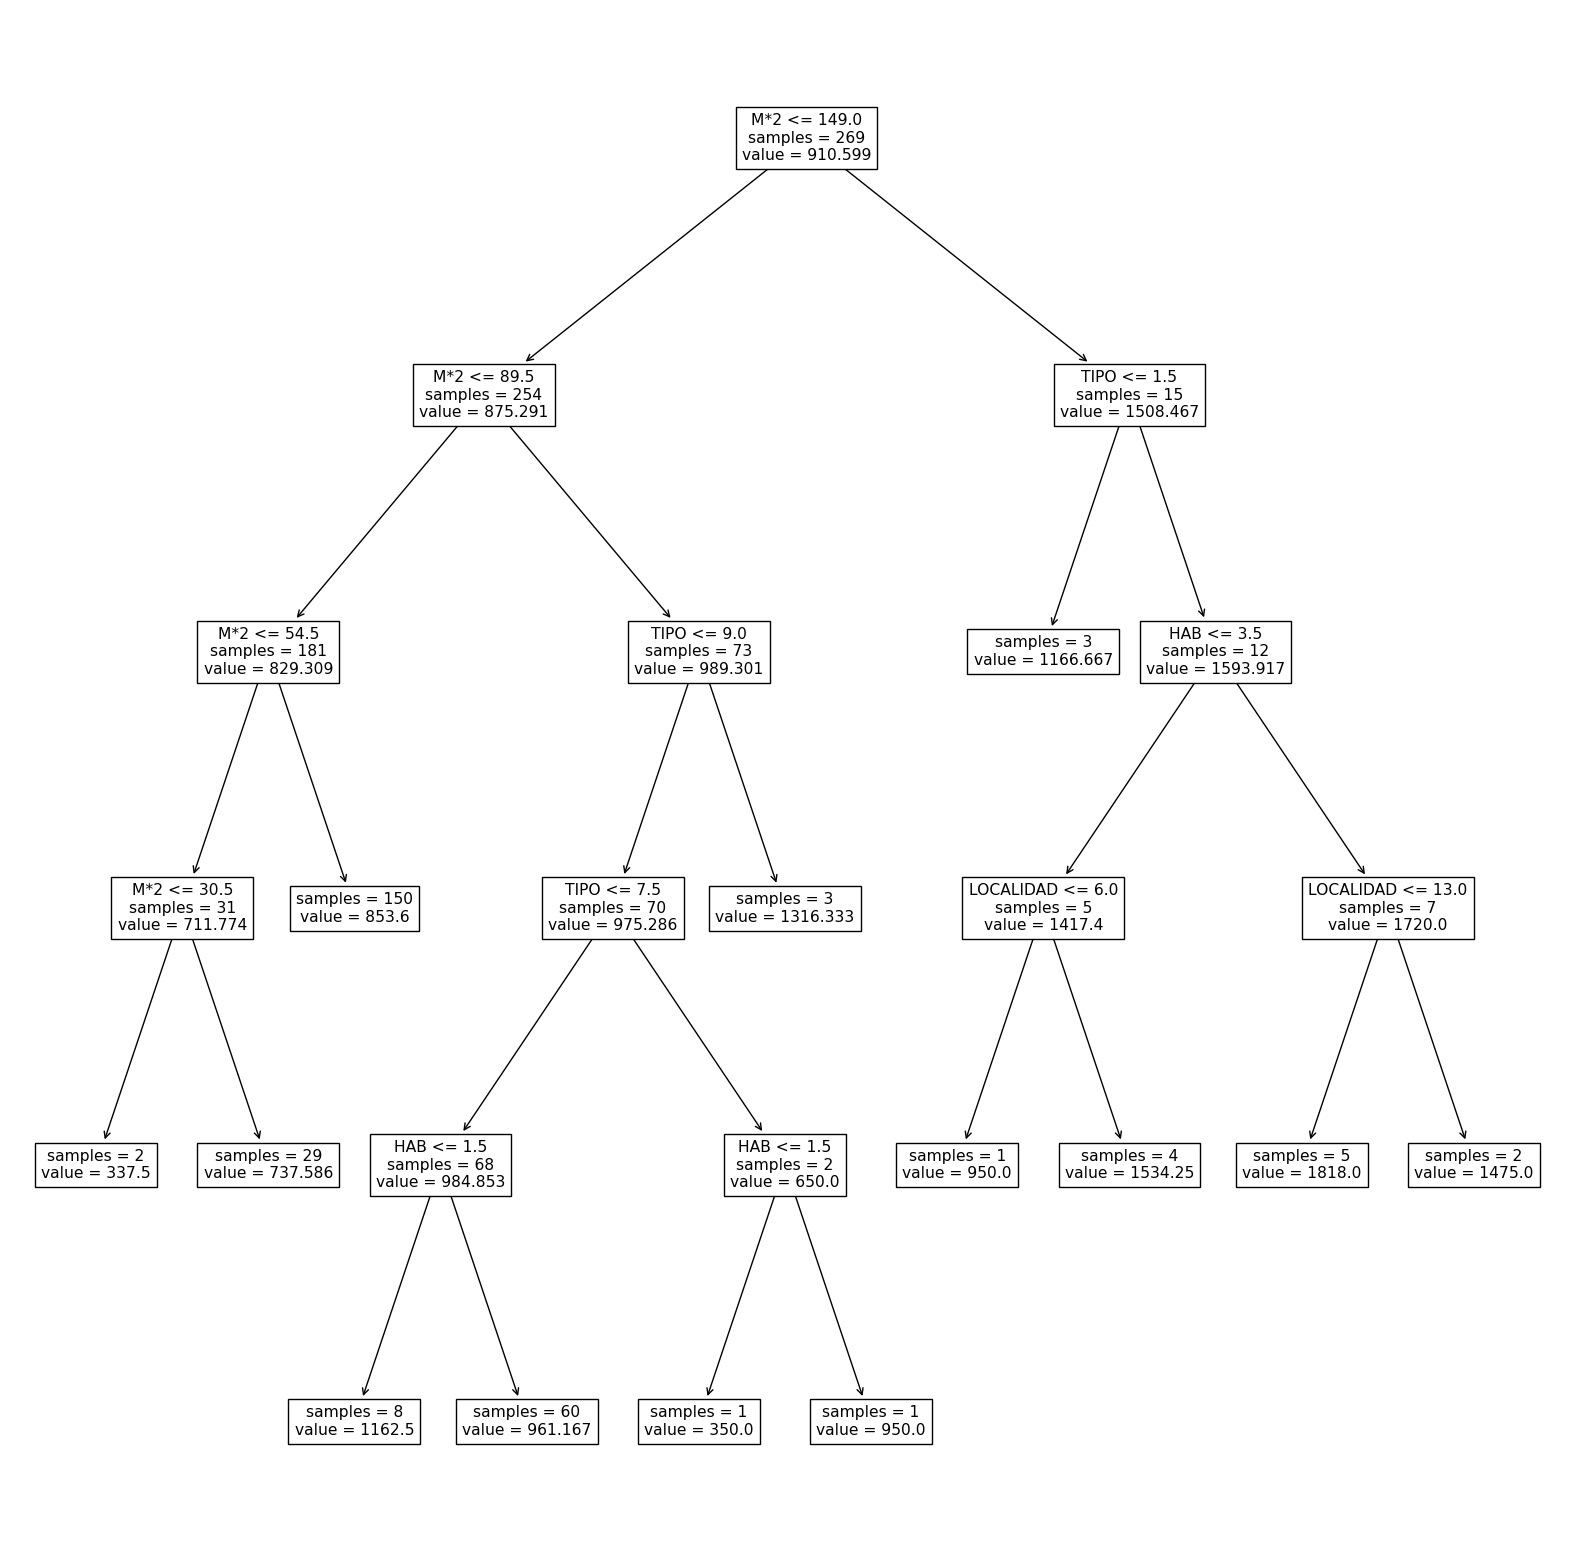

In [369]:
# graph, = print_tree(regTree, features=list(X_train.columns))
# Image(graph.create_png())
plt.figure(figsize=(20, 20))
sklearn.tree.plot_tree(regTree, feature_names=list(X_train.columns), class_names=['PRECIO'], impurity=False)
plt.savefig('regressor_tree.png')

# Predictive model application on real data

## Importing and cleaning data

In [23]:
sale_og_df = pd.read_csv('habitaclia_madridsur_compra.csv')
sale_og_df

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR
0,https://www.habitaclia.com/comprar-piso-con_as...,Piso,Calle carolina coronado,Piso con ascensor,Parla,Centro,70,1,1,1270.0,88900,No,Sí
1,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle río jordán,Piso con 3 habitaciones,Parla,Parque Inlasa,80,3,1,1312.0,104990,10000,-
2,https://www.habitaclia.com/comprar-piso-casco_...,Piso,Reverenda madre maría antonia,NaN,Ciempozuelos,Casco Antiguo Norte,75,3,1,1440.0,108000,No,-
3,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle ampurdán,Piso con 3 habitaciones con ascensor y aire ac...,Leganés,Zarzaquemada,65,3,1,2385.0,155000,15000,Sí
4,https://www.habitaclia.com/comprar-piso-en_ven...,Piso,Juan de la Cierva,Piso en venta en juan de la cierva,Getafe,Juan de la Cierva,70,2,1,2286.0,159990,No,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4640,https://www.habitaclia.com/comprar-casa-el_ber...,Casa,"Calle suiza, 10",El bercial / calle suiza,Getafe,El Bercial,352,6,5,1903.0,670000,30000,-
4641,https://www.habitaclia.com/comprar-piso-loranc...,Piso,"Urbanización nuevo versalles, s/n",Loranca / urbanización nuevo versalles,Fuenlabrada,Loranca,98,3,2,1739.0,170400,No,-
4642,https://www.habitaclia.com/comprar-piso-zarzaq...,Piso,"Calle de la rioja, 63",Zarzaquemada / calle de la rioja,Leganés,Zarzaquemada,31,1,1,3177.0,98500,5000,-
4643,https://www.habitaclia.com/comprar-casa_adosad...,Casa adosada,"Calle oporto, 34",La fortuna,Leganés,La Fortuna,225,3,3,2289.0,515000,No,-


In [25]:
rent_df = pd.read_csv('habitaclia.csv')
rent_df = rent_df[['TIPO', 'LOCALIDAD', 'ZONA', 'M*2', 'HAB', 'BAÑOS', 'PRECIO']]

In [568]:
sale_df['TIPO'].unique()

array(['Piso', 'Casa pareada', 'Ático', 'Chalet', 'Casa adosada',
       'Planta baja', 'Casa', 'Apartamento', 'Dúplex', 'Tríplex', 'Loft',
       '84 Viviendas. Getafe. Jardines de Toled'], dtype=object)

In [27]:
type_lst = list(rent_df.TIPO.unique())
sale_df = sale_og_df[sale_og_df['TIPO'].isin(type_lst)]
sale_df

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR
0,https://www.habitaclia.com/comprar-piso-con_as...,Piso,Calle carolina coronado,Piso con ascensor,Parla,Centro,70,1,1,1270.0,88900,No,Sí
1,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle río jordán,Piso con 3 habitaciones,Parla,Parque Inlasa,80,3,1,1312.0,104990,10000,-
2,https://www.habitaclia.com/comprar-piso-casco_...,Piso,Reverenda madre maría antonia,NaN,Ciempozuelos,Casco Antiguo Norte,75,3,1,1440.0,108000,No,-
3,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle ampurdán,Piso con 3 habitaciones con ascensor y aire ac...,Leganés,Zarzaquemada,65,3,1,2385.0,155000,15000,Sí
4,https://www.habitaclia.com/comprar-piso-en_ven...,Piso,Juan de la Cierva,Piso en venta en juan de la cierva,Getafe,Juan de la Cierva,70,2,1,2286.0,159990,No,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4640,https://www.habitaclia.com/comprar-casa-el_ber...,Casa,"Calle suiza, 10",El bercial / calle suiza,Getafe,El Bercial,352,6,5,1903.0,670000,30000,-
4641,https://www.habitaclia.com/comprar-piso-loranc...,Piso,"Urbanización nuevo versalles, s/n",Loranca / urbanización nuevo versalles,Fuenlabrada,Loranca,98,3,2,1739.0,170400,No,-
4642,https://www.habitaclia.com/comprar-piso-zarzaq...,Piso,"Calle de la rioja, 63",Zarzaquemada / calle de la rioja,Leganés,Zarzaquemada,31,1,1,3177.0,98500,5000,-
4643,https://www.habitaclia.com/comprar-casa_adosad...,Casa adosada,"Calle oporto, 34",La fortuna,Leganés,La Fortuna,225,3,3,2289.0,515000,No,-


In [582]:
sale_df['LOCALIDAD'].unique()

array(['Parla', 'Ciempozuelos', 'Leganés', 'Getafe', 'Fuenlabrada',
       'Serranillos del Valle', 'Pinto', 'Valdemoro', 'Alcorcón',
       'Móstoles', 'Arroyomolinos', 'Moraleja de Enmedio',
       'Humanes de Madrid', 'Griñón', 'Casarrubuelos',
       'Cubas de la Sagra', 'Torrejón de la Calzada',
       'Torrejón de Velasco', 'Batres'], dtype=object)

In [29]:
loc_lst = list(rent_df.LOCALIDAD.unique())
sale_df = sale_df[sale_df['LOCALIDAD'].isin(loc_lst)]
sale_df

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR
0,https://www.habitaclia.com/comprar-piso-con_as...,Piso,Calle carolina coronado,Piso con ascensor,Parla,Centro,70,1,1,1270.0,88900,No,Sí
1,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle río jordán,Piso con 3 habitaciones,Parla,Parque Inlasa,80,3,1,1312.0,104990,10000,-
2,https://www.habitaclia.com/comprar-piso-casco_...,Piso,Reverenda madre maría antonia,NaN,Ciempozuelos,Casco Antiguo Norte,75,3,1,1440.0,108000,No,-
3,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle ampurdán,Piso con 3 habitaciones con ascensor y aire ac...,Leganés,Zarzaquemada,65,3,1,2385.0,155000,15000,Sí
4,https://www.habitaclia.com/comprar-piso-en_ven...,Piso,Juan de la Cierva,Piso en venta en juan de la cierva,Getafe,Juan de la Cierva,70,2,1,2286.0,159990,No,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4640,https://www.habitaclia.com/comprar-casa-el_ber...,Casa,"Calle suiza, 10",El bercial / calle suiza,Getafe,El Bercial,352,6,5,1903.0,670000,30000,-
4641,https://www.habitaclia.com/comprar-piso-loranc...,Piso,"Urbanización nuevo versalles, s/n",Loranca / urbanización nuevo versalles,Fuenlabrada,Loranca,98,3,2,1739.0,170400,No,-
4642,https://www.habitaclia.com/comprar-piso-zarzaq...,Piso,"Calle de la rioja, 63",Zarzaquemada / calle de la rioja,Leganés,Zarzaquemada,31,1,1,3177.0,98500,5000,-
4643,https://www.habitaclia.com/comprar-casa_adosad...,Casa adosada,"Calle oporto, 34",La fortuna,Leganés,La Fortuna,225,3,3,2289.0,515000,No,-


In [31]:
sale_df = sale_df[(sale_df['M*2']<450) &
                  (sale_df['HAB']<6) &
                  (sale_df['BAÑOS']<5)]
new_og_sale_df = sale_df.reset_index()[list(sale_df.columns)]
new_og_sale_df

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR
0,https://www.habitaclia.com/comprar-piso-con_as...,Piso,Calle carolina coronado,Piso con ascensor,Parla,Centro,70,1,1,1270.0,88900,No,Sí
1,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle río jordán,Piso con 3 habitaciones,Parla,Parque Inlasa,80,3,1,1312.0,104990,10000,-
2,https://www.habitaclia.com/comprar-piso-casco_...,Piso,Reverenda madre maría antonia,NaN,Ciempozuelos,Casco Antiguo Norte,75,3,1,1440.0,108000,No,-
3,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle ampurdán,Piso con 3 habitaciones con ascensor y aire ac...,Leganés,Zarzaquemada,65,3,1,2385.0,155000,15000,Sí
4,https://www.habitaclia.com/comprar-piso-en_ven...,Piso,Juan de la Cierva,Piso en venta en juan de la cierva,Getafe,Juan de la Cierva,70,2,1,2286.0,159990,No,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,https://www.habitaclia.com/comprar-piso-casco_...,Piso,"San sebastian 15 bis, 15",Casco antiguo sur / san sebastian 15 bis,Ciempozuelos,Casco Antiguo Sur,129,3,2,1550.0,200000,No,-
4439,https://www.habitaclia.com/comprar-piso-loranc...,Piso,"Urbanización nuevo versalles, s/n",Loranca / urbanización nuevo versalles,Fuenlabrada,Loranca,98,3,2,1739.0,170400,No,-
4440,https://www.habitaclia.com/comprar-piso-zarzaq...,Piso,"Calle de la rioja, 63",Zarzaquemada / calle de la rioja,Leganés,Zarzaquemada,31,1,1,3177.0,98500,5000,-
4441,https://www.habitaclia.com/comprar-casa_adosad...,Casa adosada,"Calle oporto, 34",La fortuna,Leganés,La Fortuna,225,3,3,2289.0,515000,No,-


## EDA

In [634]:
new_og_sale_df[['M*2', 'HAB', 'BAÑOS', 'PRECIO']].describe()

,M*2,HAB,BAÑOS,PRECIO
count,4443.000000,4443.000000,4443.000000,4.443000e+03
mean,113.097907,2.957911,1.695026,2.195542e+05
std,61.413480,0.808990,0.795892,1.067906e+05
min,1.000000,1.000000,1.000000,3.425700e+04
25%,75.000000,3.000000,1.000000,1.398500e+05
50%,90.000000,3.000000,2.000000,1.860000e+05
75%,123.000000,3.000000,2.000000,2.740000e+05
max,440.000000,5.000000,4.000000,1.600000e+06


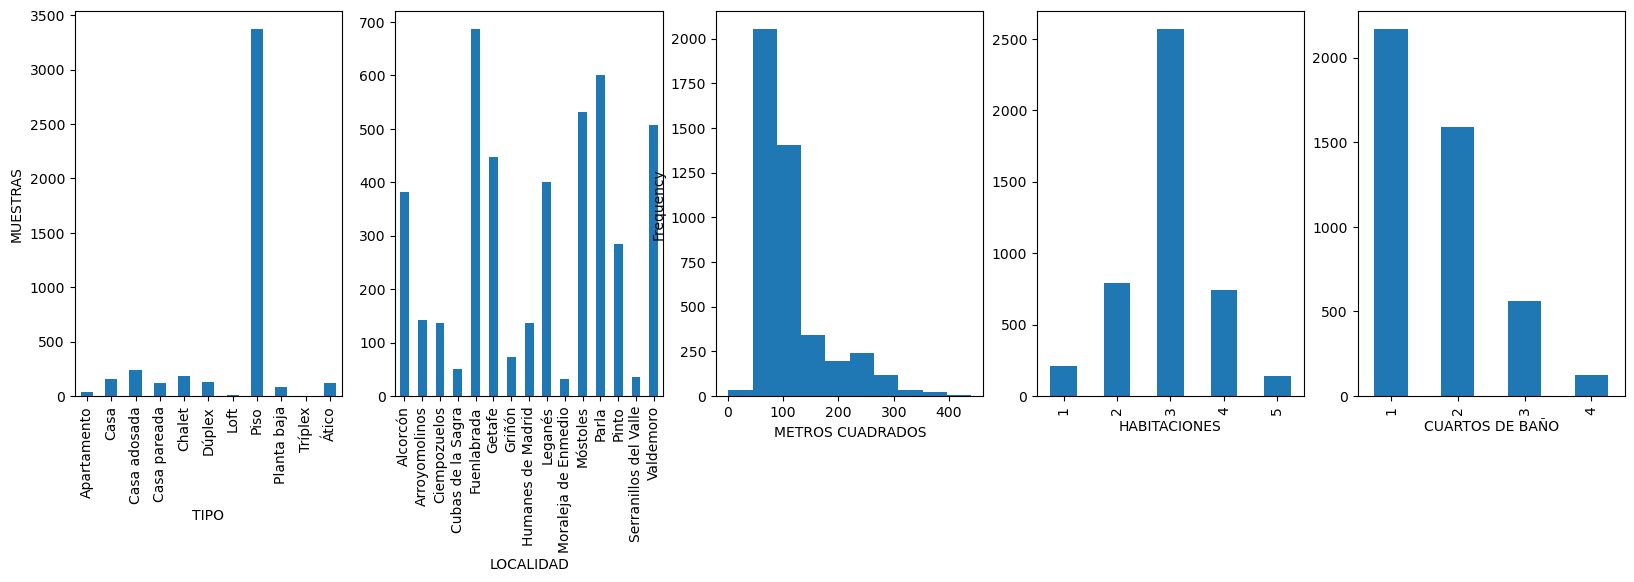

In [630]:
fig = plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
new_og_sale_df.groupby('TIPO').count()['LOCALIDAD'].plot(kind='bar')
plt.ylabel('MUESTRAS')
plt.subplot(1, 5, 2)
new_og_sale_df.groupby('LOCALIDAD').count()['TIPO'].plot(kind='bar')
plt.subplot(1, 5, 3)
new_og_sale_df['M*2'].plot(kind='hist')
plt.xlabel('METROS CUADRADOS')
plt.subplot(1, 5, 4)
new_og_sale_df.groupby('HAB').count()['LOCALIDAD'].plot(kind='bar')
plt.xlabel('HABITACIONES')
plt.subplot(1, 5, 5)
new_og_sale_df.groupby('BAÑOS').count()['LOCALIDAD'].plot(kind='bar')
plt.xlabel('CUARTOS DE BAÑO')


plt.show()

## Data pre-processing

In [33]:
sale_df = new_og_sale_df[['TIPO', 'LOCALIDAD', 'M*2', 'HAB', 'BAÑOS']]
sale_df

,TIPO,LOCALIDAD,M*2,HAB,BAÑOS
0,Piso,Parla,70,1,1
1,Piso,Parla,80,3,1
2,Piso,Ciempozuelos,75,3,1
3,Piso,Leganés,65,3,1
4,Piso,Getafe,70,2,1
...,...,...,...,...,...
4438,Piso,Ciempozuelos,129,3,2
4439,Piso,Fuenlabrada,98,3,2
4440,Piso,Leganés,31,1,1
4441,Casa adosada,Leganés,225,3,3


In [35]:
sale_df['TIPO'] = sale_df['TIPO'].replace(house_type)
dummies_loc = pd.get_dummies(sale_df[['LOCALIDAD']])
sale_df = pd.concat([dummies_loc, sale_df[['TIPO', 'M*2', 'HAB', 'BAÑOS']]], axis=1)
sale_df

C:\Users\charl\AppData\Local\Temp\ipykernel_1880\654810583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sale_df['TIPO'] = sale_df['TIPO'].replace(house_type)


,LOCALIDAD_Alcorcón,LOCALIDAD_Arroyomolinos,LOCALIDAD_Ciempozuelos,LOCALIDAD_Cubas de la Sagra,LOCALIDAD_Fuenlabrada,LOCALIDAD_Getafe,LOCALIDAD_Griñón,LOCALIDAD_Humanes de Madrid,LOCALIDAD_Leganés,LOCALIDAD_Moraleja de Enmedio,LOCALIDAD_Móstoles,LOCALIDAD_Parla,LOCALIDAD_Pinto,LOCALIDAD_Serranillos del Valle,LOCALIDAD_Valdemoro,TIPO,M*2,HAB,BAÑOS
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,70,1,1
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,80,3,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,75,3,1
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,65,3,1
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4,70,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,129,3,2
4439,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,98,3,2
4440,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,31,1,1
4441,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,10,225,3,3


In [37]:
model_estim = list(lr.predict(sale_df))
pred_rent = [round(n) for n in model_estim] 
len(pred_rent)

4443

In [39]:
# sale_df_with_pred = 
new_og_sale_df['ALQUILER ESTIMADO']=pred_rent
new_og_sale_df

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR,ALQUILER ESTIMADO
0,https://www.habitaclia.com/comprar-piso-con_as...,Piso,Calle carolina coronado,Piso con ascensor,Parla,Centro,70,1,1,1270.0,88900,No,Sí,692
1,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle río jordán,Piso con 3 habitaciones,Parla,Parque Inlasa,80,3,1,1312.0,104990,10000,-,822
2,https://www.habitaclia.com/comprar-piso-casco_...,Piso,Reverenda madre maría antonia,NaN,Ciempozuelos,Casco Antiguo Norte,75,3,1,1440.0,108000,No,-,760
3,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle ampurdán,Piso con 3 habitaciones con ascensor y aire ac...,Leganés,Zarzaquemada,65,3,1,2385.0,155000,15000,Sí,870
4,https://www.habitaclia.com/comprar-piso-en_ven...,Piso,Juan de la Cierva,Piso en venta en juan de la cierva,Getafe,Juan de la Cierva,70,2,1,2286.0,159990,No,-,875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,https://www.habitaclia.com/comprar-piso-casco_...,Piso,"San sebastian 15 bis, 15",Casco antiguo sur / san sebastian 15 bis,Ciempozuelos,Casco Antiguo Sur,129,3,2,1550.0,200000,No,-,942
4439,https://www.habitaclia.com/comprar-piso-loranc...,Piso,"Urbanización nuevo versalles, s/n",Loranca / urbanización nuevo versalles,Fuenlabrada,Loranca,98,3,2,1739.0,170400,No,-,950
4440,https://www.habitaclia.com/comprar-piso-zarzaq...,Piso,"Calle de la rioja, 63",Zarzaquemada / calle de la rioja,Leganés,Zarzaquemada,31,1,1,3177.0,98500,5000,-,683
4441,https://www.habitaclia.com/comprar-casa_adosad...,Casa adosada,"Calle oporto, 34",La fortuna,Leganés,La Fortuna,225,3,3,2289.0,515000,No,-,1574


In [53]:
new_og_sale_df.to_csv('estimaciones_4443.csv', index=False)

In [73]:
rent_bruta = round(100*( (new_og_sale_df['ALQUILER ESTIMADO']*12) / (new_og_sale_df['PRECIO'])), 1)
# rent_bruta_fin_20 = 100*( (new_og_sale_df['ALQUILER ESTIMADO']*12) / (new_og_sale_df['PRECIO']*0.2))
new_og_sale_df['RENT. BRUTA'] = rent_bruta
new_og_sale_df

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR,ALQUILER ESTIMADO,RENT. BRUTA
0,https://www.habitaclia.com/comprar-piso-con_as...,Piso,Calle carolina coronado,Piso con ascensor,Parla,Centro,70,1,1,1270.0,88900,No,Sí,692,9.3
1,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle río jordán,Piso con 3 habitaciones,Parla,Parque Inlasa,80,3,1,1312.0,104990,10000,-,822,9.4
2,https://www.habitaclia.com/comprar-piso-casco_...,Piso,Reverenda madre maría antonia,NaN,Ciempozuelos,Casco Antiguo Norte,75,3,1,1440.0,108000,No,-,760,8.4
3,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle ampurdán,Piso con 3 habitaciones con ascensor y aire ac...,Leganés,Zarzaquemada,65,3,1,2385.0,155000,15000,Sí,870,6.7
4,https://www.habitaclia.com/comprar-piso-en_ven...,Piso,Juan de la Cierva,Piso en venta en juan de la cierva,Getafe,Juan de la Cierva,70,2,1,2286.0,159990,No,-,875,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,https://www.habitaclia.com/comprar-piso-casco_...,Piso,"San sebastian 15 bis, 15",Casco antiguo sur / san sebastian 15 bis,Ciempozuelos,Casco Antiguo Sur,129,3,2,1550.0,200000,No,-,942,5.7
4439,https://www.habitaclia.com/comprar-piso-loranc...,Piso,"Urbanización nuevo versalles, s/n",Loranca / urbanización nuevo versalles,Fuenlabrada,Loranca,98,3,2,1739.0,170400,No,-,950,6.7
4440,https://www.habitaclia.com/comprar-piso-zarzaq...,Piso,"Calle de la rioja, 63",Zarzaquemada / calle de la rioja,Leganés,Zarzaquemada,31,1,1,3177.0,98500,5000,-,683,8.3
4441,https://www.habitaclia.com/comprar-casa_adosad...,Casa adosada,"Calle oporto, 34",La fortuna,Leganés,La Fortuna,225,3,3,2289.0,515000,No,-,1574,3.7


In [59]:
new_og_sale_df

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR,ALQUILER ESTIMADO,RENT. BRUTA
0,https://www.habitaclia.com/comprar-piso-con_as...,Piso,Calle carolina coronado,Piso con ascensor,Parla,Centro,70,1,1,1270.0,88900,No,Sí,692,9.340832
1,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle río jordán,Piso con 3 habitaciones,Parla,Parque Inlasa,80,3,1,1312.0,104990,10000,-,822,9.395180
2,https://www.habitaclia.com/comprar-piso-casco_...,Piso,Reverenda madre maría antonia,NaN,Ciempozuelos,Casco Antiguo Norte,75,3,1,1440.0,108000,No,-,760,8.444444
3,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle ampurdán,Piso con 3 habitaciones con ascensor y aire ac...,Leganés,Zarzaquemada,65,3,1,2385.0,155000,15000,Sí,870,6.735484
4,https://www.habitaclia.com/comprar-piso-en_ven...,Piso,Juan de la Cierva,Piso en venta en juan de la cierva,Getafe,Juan de la Cierva,70,2,1,2286.0,159990,No,-,875,6.562910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,https://www.habitaclia.com/comprar-piso-casco_...,Piso,"San sebastian 15 bis, 15",Casco antiguo sur / san sebastian 15 bis,Ciempozuelos,Casco Antiguo Sur,129,3,2,1550.0,200000,No,-,942,5.652000
4439,https://www.habitaclia.com/comprar-piso-loranc...,Piso,"Urbanización nuevo versalles, s/n",Loranca / urbanización nuevo versalles,Fuenlabrada,Loranca,98,3,2,1739.0,170400,No,-,950,6.690141
4440,https://www.habitaclia.com/comprar-piso-zarzaq...,Piso,"Calle de la rioja, 63",Zarzaquemada / calle de la rioja,Leganés,Zarzaquemada,31,1,1,3177.0,98500,5000,-,683,8.320812
4441,https://www.habitaclia.com/comprar-casa_adosad...,Casa adosada,"Calle oporto, 34",La fortuna,Leganés,La Fortuna,225,3,3,2289.0,515000,No,-,1574,3.667573


In [ ]:
create_sqlite_database("my_new.db")

In [ ]:
con = sqlite3.connect('my.db')

og_df.to_sql('Habitaclia', con, if_exists='replace', index=False, method='multi')

cursor = con.cursor()
query = 'SELECT * FROM Habitaclia'

mydb_df = pd.read_sql_query(query, con)
mydb_df

In [113]:
new_og_sale_df[(new_og_sale_df['LOCALIDAD']=='Alcorcón') &
               (new_og_sale_df['TIPO']=='Piso')          &
               (new_og_sale_df['RENT. BRUTA']<=8.0)       ].sort_values(by='RENT. BRUTA', ascending=False)

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR,ALQUILER ESTIMADO,RENT. BRUTA
4283,https://www.habitaclia.com/comprar-piso-lote_u...,Piso,Zona Renfe,Lote unico: finca registral: urbana.- numero v...,Alcorcón,Zona Renfe,57,2,1,2240.0,127680,No,-,852,8.0
2507,https://www.habitaclia.com/comprar-piso-con_2_...,Piso,Casco Antiguo,Piso con 2 habitaciones amueblado con calefacción,Alcorcón,Casco Antiguo,52,2,1,2423.0,126000,No,-,840,8.0
2228,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Paseo castilla,Piso con 3 habitaciones con calefacción y aire...,Alcorcón,Zona Renfe,86,3,1,1698.0,146000,No,-,974,8.0
3359,https://www.habitaclia.com/comprar-piso-zona_r...,Piso,Princesa,NaN,Alcorcón,Zona Renfe,47,2,1,2650.0,124545,17955,-,828,8.0
4317,https://www.habitaclia.com/comprar-piso-en_ven...,Piso,Casco Antiguo,"Piso en venta en alcorcón, madrid",Alcorcón,Casco Antiguo,66,2,1,1989.0,131300,No,-,874,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,https://www.habitaclia.com/comprar-piso-espect...,Piso,"Calle oslo, 52",Espectacular ático dúplex,Alcorcón,Parque Oeste-Fuente Cisneros,138,3,2,3116.0,430000,No,-,1151,3.2
2595,https://www.habitaclia.com/comprar-piso-precio...,Piso,Valderas-Los Castillos,Precioso bajo de dos plantas con dos patios,Alcorcón,Valderas-Los Castillos,213,4,2,2484.0,529000,No,-,1383,3.1
1610,https://www.habitaclia.com/comprar-piso-parque...,Piso,Parque Oeste-Fuente Cisneros,NaN,Alcorcón,Parque Oeste-Fuente Cisneros,88,2,1,4091.0,360000,No,-,926,3.1
4428,https://www.habitaclia.com/comprar-piso-partic...,Piso,"Avenida lisboa, sn",Particular vende piso en torre parque lisboa,Alcorcón,Parque Lisboa-La Paz,135,3,2,3296.0,445000,No,-,1144,3.1


In [197]:
new_og_sale_df[(new_og_sale_df['LOCALIDAD']=='Alcorcón') &
               (new_og_sale_df['TIPO']=='Piso') &
               (new_og_sale_df['RENT. BRUTA']>5)&
               (new_og_sale_df['RENT. BRUTA']<10)   ].sort_values(by='RENT. BRUTA', ascending=False).reset_index()[list(new_og_sale_df.columns)]

,URL,TIPO,UBICACIÓN,INFO,LOCALIDAD,ZONA,M*2,HAB,BAÑOS,PRECIO/m*2,PRECIO,DESCUENTO,ASCENSOR,ALQUILER ESTIMADO,RENT. BRUTA
0,https://www.habitaclia.com/comprar-piso-con_2_...,Piso,Calle de los guindales,Piso con 2 habitaciones,Alcorcón,Zona Renfe,60,2,1,1750.0,105000,No,-,859,9.8
1,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Zona Renfe,Piso con 3 habitaciones con calefacción,Alcorcón,Zona Renfe,75,3,1,1587.0,119000,5000,-,948,9.6
2,https://www.habitaclia.com/comprar-piso-en_zon...,Piso,Cl guindales,Alcorcón/piso,Alcorcón,Zona Renfe,51,2,1,2059.0,105000,No,-,838,9.6
3,https://www.habitaclia.com/comprar-piso-solvia...,Piso,C/ guindales,Solvia inmobiliaria - piso alcorcón,Alcorcón,Zona Renfe,51,2,1,2059.0,105000,No,-,838,9.6
4,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Zona Renfe,Piso con 3 habitaciones,Alcorcón,Zona Renfe,62,3,1,1857.0,115164,No,-,917,9.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,https://www.habitaclia.com/comprar-piso-valder...,Piso,Valderas-Los Castillos,NaN,Alcorcón,Valderas-Los Castillos,122,4,2,2213.0,270000,25000,-,1166,5.2
214,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle ministro fernández ordóñez,Piso con 3 habitaciones con ascensor y calefac...,Alcorcón,Parque Lisboa-La Paz,84,3,1,2726.0,229000,No,Sí,970,5.1
215,https://www.habitaclia.com/comprar-piso-con_3_...,Piso,Calle alfredo nobel,Piso con 3 habitaciones con ascensor,Alcorcón,Prado de Santo Domingo,83,3,2,2880.0,239000,No,Sí,1020,5.1
216,https://www.habitaclia.com/comprar-piso-reserv...,Piso,Zona Renfe,Reservado !!,Alcorcón,Zona Renfe,85,3,1,2706.0,230000,11000,-,972,5.1
